# Train different Neural Networks on a Traffic Sign Detection Dataset

In [57]:
import matplotlib.pyplot as plt
from copy import deepcopy
import os
from enum import Enum
from abc import ABC, abstractmethod
from typing import Optional
import random
import numpy as np
from PIL import Image
import yaml

In [60]:
class DataType(Enum):
    TRAIN = 1
    TEST = 2
    VALID = 3

class Label:
    def __init__(self, raw_data: str) -> None:
        split_data = raw_data.split(' ')
        self.category = int(split_data[0])
        self.center_x, self.center_y, self.width, self.height = map(float, split_data[1:])

class Entry:
    def __init__(self, image: np.array, labels: list[Label], image_name: str) -> None:
        self.image = image
        self.labels = labels
        self.image_name = image_name


dataset_path = 'data/traffic-signs-detection'
info_file = os.path.join(dataset_path, 'car/data.yaml')
categories = yaml.load(open(info_file), Loader=yaml.FullLoader)['names']

img_size = 64
min_bounding_box_size = 0.3
only_single_label = True
forbidden_file_prefixes = ['FisheyeCamera', 'road']
grayscale = False

def load_image_data(type: DataType):
    data_path = os.path.join(dataset_path, 'car', type.name.lower())
    images_path = os.path.join(data_path, 'images')
    labels_path = os.path.join(data_path, 'labels')

    entries = []
    files_in_folder = os.listdir(images_path)
    print(f'Scanning {len(files_in_folder)} entries from {images_path} and {labels_path}...')

    for image_name in files_in_folder:
        image = plt.imread(os.path.join(images_path, image_name))
        image = np.array(Image.fromarray(image).resize((img_size, img_size)))

        if grayscale:
            image = np.mean(image, axis=2)
        
        image = image / 255.0
        labels_raw = open(os.path.join(labels_path, image_name.replace('.jpg', '.txt'))).read().split('\n')
        labels = [Label(label) for label in labels_raw if label]

        if (
            only_single_label and len(labels) > 1
            or len(labels) == 0
            or any([image_name.startswith(prefix) for prefix in forbidden_file_prefixes])
            or any([label.width < min_bounding_box_size or label.height < min_bounding_box_size for label in labels])
        ):
            continue

        entries.append(Entry(image, labels, image_name))

    return entries

train_data = load_image_data(DataType.TRAIN)
validate_data = load_image_data(DataType.VALID)
test_data = load_image_data(DataType.TEST)

print(f'Loaded {len(train_data)} training images, {len(validate_data)} validation images and {len(test_data)} test images')

Scanning 3530 entries from data/traffic-signs-detection/car/train/images and data/traffic-signs-detection/car/train/labels...
Scanning 801 entries from data/traffic-signs-detection/car/valid/images and data/traffic-signs-detection/car/valid/labels...
Scanning 638 entries from data/traffic-signs-detection/car/test/images and data/traffic-signs-detection/car/test/labels...
Loaded 1747 training images, 450 validation images and 287 test images


In [ ]:
num_images = 6
categories_to_display = [0, 3, 13, 14]
fig, axs = plt.subplots(len(categories_to_display), num_images, figsize=(num_images * 2, len(categories_to_display) * 2))
print(f'Displaying {num_images} random images from each of the following categories: {", ".join([categories[category] for category in categories_to_display])}')

for idx, category in enumerate(categories_to_display):
    category_entries = [entry for entry in validate_data if entry.labels[0].category == category]
    
    if len(category_entries) >= num_images:
        selected_entries = random.sample(category_entries, num_images)
    else:
        selected_entries = category_entries
    
    for i, entry in enumerate(selected_entries):
        axs[idx, i].imshow(entry.image, cmap='gray')
        axs[idx, i].axis('off')
        if i == 0:
            axs[idx, i].set_title(categories[category])
            
        for label in entry.labels:
            x = label.center_x * img_size
            y = label.center_y * img_size
            w = label.width * img_size
            h = label.height * img_size
            rect = plt.Rectangle((x - w / 2, y - h / 2), w, h, fill=False, color='r')
            axs[idx, i].add_patch(rect)

for ax in axs.flat:
    ax.axis('off')

plt.show()


In [140]:
def get_data(data: list[Entry], start = None, stop = None):
    images = np.array([entry.image for entry in data[start:stop]])
    labels = np.array([entry.labels[0].category for entry in data[start:stop]])
    return images, labels

train_images, train_labels = get_data(train_data)
validate_images, validate_labels = get_data(validate_data)
test_images, test_labels = get_data(test_data)

### Hyperparameter search
Trying to reach the maximum accuracy with only dense layers and dropout, no fancy 2d kernels, data augmentation or l1/12-regularization

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import keras_tuner as kt

class CustomModel(kt.HyperModel):
    def build(self, hp):
        tf.keras.backend.clear_session()
        model = Sequential()

        # Define input shape
        model.add(Input(shape=(img_size, img_size, 3)))
        model.add(Flatten())
        
        # Search for number of layers between 1 and 3
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
            model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0, max_value=0.5, step=0.05)))

        # Output layer
        model.add(Dense(len(categories), activation='softmax'))

        # Compile the model with an optimizer that has a tunable learning rate
        model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log')), 
                    loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model
    
    # thanks to https://github.com/keras-team/keras-tuner/issues/122#issuecomment-544648268
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [2 ** n for n in range(1, 11)]),
            verbose=0,
            **kwargs,
        )

# Set up the tuner
tuner = kt.Hyperband(
    CustomModel(),
    objective='val_accuracy',
    max_epochs=200,
    hyperband_iterations=6,
    directory='models',
    project_name='ann_hyperparam_search'
)

class ClearGPUCallback(tf.keras.callbacks.Callback):
    def on_train_end(self):
        tf.keras.backend.clear_session()

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=12, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
gpu_clear_callback = ClearGPUCallback()

# Search for the best hyperparameters
tuner.search(train_images, train_labels,
             validation_data=(validate_images, validate_labels),
             callbacks=[lr_scheduler, early_stop])

print('Search complete!')
# Get the best model
model = tuner.get_best_models()[0]
print(model.summary())
trials = tuner.oracle.get_best_trials()[:10]

for trial in trials:
    print(trial.summary())

In [150]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = Sequential()

# validation accuracy would always stagnate at 75%, the model could go to 99% training accuracy with 4096 - 1024 - 256 but would overfit
# that's why we need dropout but more neurons to compensate for the dropout, i don't wanna use l1/l2 or augmentation - just plain ann
# training + validation accuracy would go to 70% with 6144 - 3072 - 1024 - 512 and 0.0001 lr, log curve and 150 epochs
# now testing with 300 epochs and 0.0002 lr
# lr 0.0002 didn't work, wonky and plateau at 50%, trying lr 0.0001 and 300 epochs -> still stopping at 70%
# may try a different optimizer if my hyperparam search over 1e-2 - 1e-6 lr, 1-3 layers (0 - 0.5 dropout & 32-512 neurons each) doesnt work
# split = int(len(train_data) * 0.8)
# np.random.shuffle(train_data)
# train_images, train_labels = get_data(train_data, None, split)
# validate_images, validate_labels = get_data(train_data, split, None)

model.add(Input(shape=(img_size, img_size, 3)))
model.add(AveragePooling2D((3, 3), strides=3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(len(categories), activation='softmax'))
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=12, min_lr=1e-6)

history = model.fit(
            train_images,
            train_labels,
            batch_size=32,
            epochs=300,
            validation_data=(validate_images, validate_labels), 
            callbacks=[lr_scheduler])

Epoch 1/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.1328 - loss: 2.7105 - val_accuracy: 0.2686 - val_loss: 2.3713 - learning_rate: 0.0010
Epoch 2/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2177 - loss: 2.3623 - val_accuracy: 0.3114 - val_loss: 2.2109 - learning_rate: 0.0010
Epoch 3/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3032 - loss: 2.2022 - val_accuracy: 0.3371 - val_loss: 2.0907 - learning_rate: 0.0010
Epoch 4/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3005 - loss: 2.0861 - val_accuracy: 0.3571 - val_loss: 2.0204 - learning_rate: 0.0010
Epoch 5/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3404 - loss: 1.9998 - val_accuracy: 0.3486 - val_loss: 1.9580 - learning_rate: 0.0010
Epoch 6/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3365 - loss: 1.9835 - val_accuracy: 0.3971 - val_loss: 1.8564 - learning_rate: 0.0010
Epoch 7/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3814 - loss: 1.8773 - val_ac

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam

# create model
model = Sequential()
model.add(Input(shape=(img_size, img_size, 3)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_images, train_labels, epochs=10, batch_size=10, validation_data=(validate_images, validate_labels))

Text(0, 0.5, 'Genauigkeit')

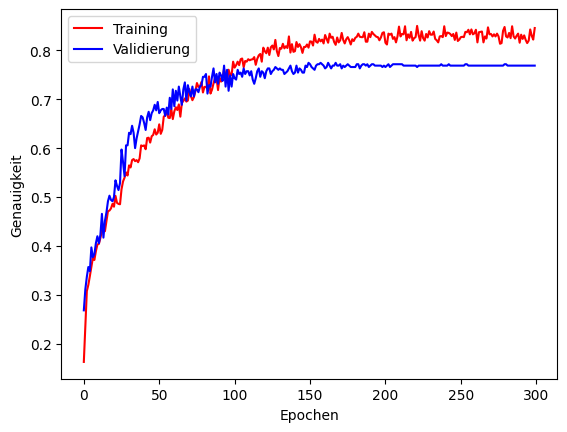

In [152]:
plt.plot(history.history['accuracy'], color='red', label='Training')
plt.plot(history.history['val_accuracy'], color='blue', label='Validierung')
plt.legend()
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')

In [ ]:
# get the output value of the first layer of the custom model
print(model.layers)

layer_models = []
for i, layer in enumerate(model.layers):
    layer_model = Sequential()
    for j in range(i + 1):
        layer_model.add(model.layers[j])
    layer_models.append(layer_model)

layer_models[1].summary()

# image = train_images[:1]
# print(image.shape)
# layer_models[1].predict(image)

# raise

# while True:
#     # keras expects a batch of images, so we need to add an additional dimension to the image
#     input_data = test_images[np.random.randint(0, len(test_images))][np.newaxis]
#     layer_output = [layer_model.predict(input_data) for layer_model in layer_models]

#     # the plot should look like this:
#     #                        Layer 1 Filter 1 weights     Layer 1 Output 1       ...       Layer n Filter 1 weights     Layer n Output 1      
#     # Original Image         ...                          ...                    ...       ...                          ...                     Predicted Category
#     #                        Layer 1 Filter n weights     Layer 1 Output n       ...       Layer n Filter n weights     Layer n Output n
#     #

#     fig, ax, plt.subplots()


#     plt.show()

input_data = test_images[np.random.randint(0, len(test_images))][np.newaxis]
layer_output = layer_models[0].predict(input_data)
# plot the original image, the weights of the first kernel and the output of the first layer
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(input_data[0])
axs[0].axis('off')
axs[0].set_title('Original Image')

weights = model.layers[0].get_weights()[0]
weights_min = weights.min()
weights_max = weights.max()
weights = (weights - weights_min) / (weights_max - weights_min)
axs[1].imshow(weights[:, :, 0, 0], cmap='gray')
axs[1].axis('off')
axs[1].set_title('First Kernel Weights')

output = layer_output[0]
axs[2].imshow(output[:, :, 0], cmap='gray')
axs[2].axis('off')
axs[2].set_title('Output of First Layer')


## What happened?
1. I suffered from exploding gradients with HeInitialization() and MeanSquaredError(). I tried gradient clipping to 1.0 but turns out I don't have exploding gradients but vanishing gradients and exploding outputs. The outputs were very high with very low gradients, weird... Possible reasons are MeanSquaredError(), ReLU() and the batch size of 1 leading to instable gradients. Other potential reason: high learning rate.
2. I changed to CrossEntropy() -> still vanishing gradients
3. LeakyReLU() -> still vanishing
4. Used RandomInitialization() and Sigmoid() activation function, works perfectly now

I'm going to try adding batch processing so it will also work, maybe something with my Softmax output function was wrong, I want to try the original architecture (128 64 LeakyReLU, CrossEntropy, Xavier but with a different output activation function to see if the code for Softmax is broken)


